In [6]:
import os
import cv2
import mediapipe as mp
import numpy as np
import math
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [7]:
# FUNCTIONS USED TO CALCULATE ANGLES

def calculate_angle(point1,point2,point3):
    a = np.array(point1) #First
    b = np.array(point2) #Mid
    c = np.array(point3) #End

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle 
    
def angle_of_singleline(point1, point2):
    """ Calculate angle of a single line """
    x_diff = point2[0] - point1[0]
    y_diff = point2[1] - point1[1]
    return math.degrees(math.atan2(y_diff, x_diff))

In [8]:
# RETRIEVES DETECTED LANDMARDS AND RESULTS USING MEDIA PIPE

def apply_detection_to_image(file):
    #import cv2
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
    sample_img = cv2.imread(file)
    results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    landmarks = results.pose_landmarks.landmark
    return landmarks, results

In [9]:
# USES MEDIAPIPE LANDMARKS TO CALCULATE ANGLES

def get_pose_landmarks(landmarks):
    # GET COORDINATES OF JOINTS
    left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
    left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
    left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

    right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
    right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]

      # CALCULATE SOME REQUIRED METRICS ANGLES

    left_elbow_angle = np.round(calculate_angle(left_shoulder,left_elbow,left_wrist))
    left_elbow_angle_hor = np.round(angle_of_singleline(left_elbow,left_wrist))
    left_knee_angle = np.round(calculate_angle(left_hip, left_knee, left_ankle))
    left_knee_angle_ver = np.round(angle_of_singleline(left_knee,left_ankle))
    left_hip_angle = np.round(calculate_angle(left_shoulder,left_hip, left_knee))

    right_elbow_angle = np.round(calculate_angle(right_shoulder,right_elbow,right_wrist))
    right_elbow_angle_hor = np.round(angle_of_singleline(right_wrist,right_elbow))
    right_knee_angle = np.round(calculate_angle(right_hip, right_knee, right_ankle))
    right_knee_angle_ver = np.round(angle_of_singleline(right_knee,right_ankle))
    right_hip_angle = np.round(calculate_angle(right_shoulder,right_hip, right_knee))

    return left_elbow_angle, left_elbow_angle_hor, left_knee_angle, left_knee_angle_ver, left_hip_angle, right_elbow_angle, right_elbow_angle_hor, right_knee_angle, right_knee_angle_ver, right_hip_angle
    

In [10]:
# PLOT OF IMAGE WITH SUPERIMPOSED LANDMARSK FOR QUALITY CHECK

def plot_figure(file, results):
    #pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

    sample_img = cv2.imread(file)

    img_copy = sample_img.copy()

    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])
 
    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

In [11]:
# DATA TRAINING READING ROUTINE (works for jpg, png)
# EXPECTS following structure:
# in folder /google_images/ there is one folder per yoga pose. For example, feft_warrior2, right_warrior2
# google_images/left_warrior2
# google_images/right_warrior2
# in each folder, there are images showing the pose
# this script reads each image, gets the landmarks with mediapie, calculate angles

image_dir = 'google_images/'
pose_examples = os.listdir(image_dir)
pose_images = {}
pose_all_data = []
pose_label = []
pose_data = []
for poses in pose_examples:
    file_list =  os.listdir(image_dir + poses)
    pose_images[poses]=file_list

pose_number = 0
for key in pose_images:
    for file in pose_images[key]:
        file_path = image_dir + key + '/' + file
        #print(file_path)
        landmarks0, results0 = apply_detection_to_image(file_path)
        markers0 = get_pose_landmarks(landmarks0)
        pose_all_data.append([key, pose_number, file_path,  markers0])
        pose_data.append(markers0)
        pose_label.append(pose_number)
        #plot_figure(file_path, results0)
    pose_number = pose_number + 1
pose_data_np = np.array(pose_data)
pose_label_np = np.array(pose_label)

#left_elbow_angle, left_elbow_angle_hor, left_knee_angle, left_knee_angle_ver, left_hip_angle, right_elbow_angle, right_elbow_angle_hor, right_knee_angle, right_knee_angle_ver, right_hip_angle
features_str = ["left_elbow_angle", "left_elbow_angle_hor", "left_knee_angle", "left_knee_angle_ver", "left_hip_angle", "right_elbow_angle", "right_elbow_angle_hor", "right_knee_angle", "right_knee_angle_ver", "right_hip_angle"]
pose_names_str = pose_examples

In [12]:
pose_names_str

['left_tree', 'left_warrior2', 'mountain', 'right_tree', 'right_warrior2']

# DECISION TREE CLASSIFIER TEST

In [ ]:
#pip install -U scikit-learn

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pickle

X_train, X_test, y_train, y_test = train_test_split(pose_data_np, pose_label_np, random_state = 2)
clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))


# save the model to disk
filename = 'yoga_poses_decisiontree.model'
pickle.dump(clf, open(filename, 'wb'))
 

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.99


## PLOT DECISION TREE

[Text(0.5, 0.9285714285714286, 'left_knee_angle_ver <= 67.0\ngini = 0.692\nsamples = 213\nvalue = [21, 66, 16, 17, 93]\nclass = right_warrior2'),
 Text(0.25, 0.7857142857142857, 'left_elbow_angle_hor <= -47.0\ngini = 0.178\nsamples = 101\nvalue = [10, 0, 0, 0, 91]\nclass = right_warrior2'),
 Text(0.125, 0.6428571428571429, 'gini = 0.0\nsamples = 10\nvalue = [10, 0, 0, 0, 0]\nclass = left_tree'),
 Text(0.375, 0.6428571428571429, 'gini = 0.0\nsamples = 91\nvalue = [0, 0, 0, 0, 91]\nclass = right_warrior2'),
 Text(0.75, 0.7857142857142857, 'right_knee_angle_ver <= 100.5\ngini = 0.599\nsamples = 112\nvalue = [11, 66, 16, 17, 2]\nclass = left_warrior2'),
 Text(0.625, 0.6428571428571429, 'right_knee_angle_ver <= 30.0\ngini = 0.726\nsamples = 50\nvalue = [11, 4, 16, 17, 2]\nclass = right_tree'),
 Text(0.5, 0.5, 'gini = 0.0\nsamples = 17\nvalue = [0, 0, 0, 17, 0]\nclass = right_tree'),
 Text(0.75, 0.5, 'left_hip_angle <= 155.5\ngini = 0.635\nsamples = 33\nvalue = [11, 4, 16, 0, 2]\nclass = mou

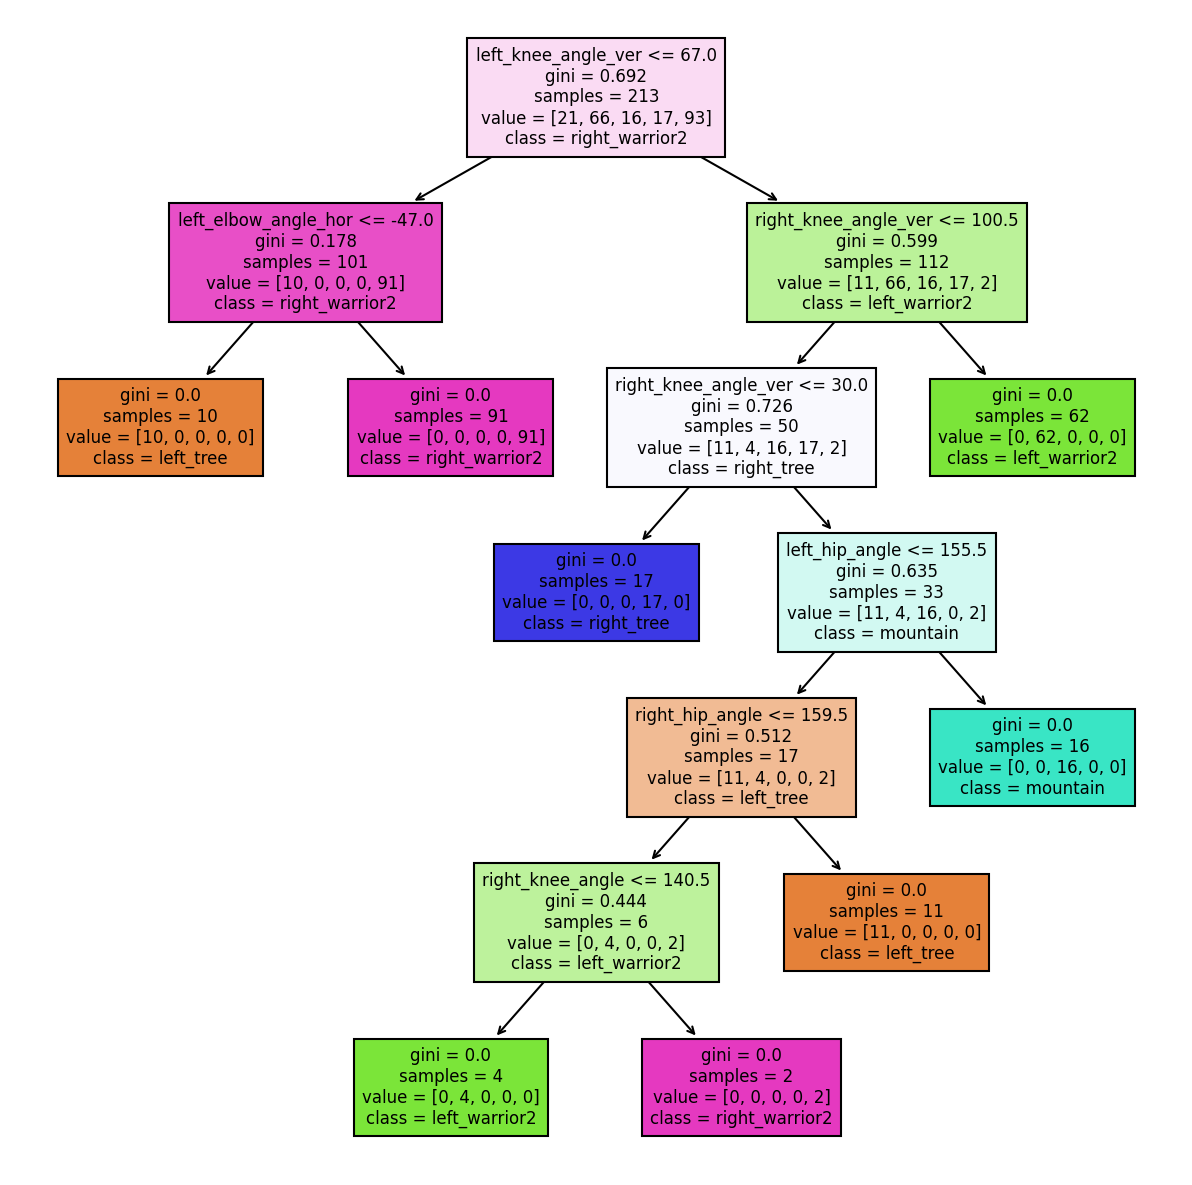

In [14]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=150)
plot_tree(clf, feature_names=features_str, class_names=pose_names_str, filled=True, fontsize=8)

#### TEST THE CODE WITH NEW IMAGES

In [18]:
file_path = "unseen_images/left_tree.jpg"
landmarks0, results0 = apply_detection_to_image(file_path)
markers0 = np.array(get_pose_landmarks(landmarks0)).reshape(1, -1)
markers0

# GET PREDICTION
predict_label = (clf.predict(markers0))
print("Predicted label: ", predict_label[0])
print("Label corresponds to pose: ", pose_names_str[predict_label[0]])

Predicted label:  0
Label corresponds to pose:  left_tree


In [ ]:
pose_names_str